<a href="https://colab.research.google.com/github/giuseppecurci/Real_Estate_Texas_Data_Analysis/blob/main/Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **0. Introduction**

Le variabili del
dataset sono:
* city: city
* year: year of reference
* month: month of reference
* sales: total number of sales
* volume: total value of sales in millions of dollars
* median_price: median sales price in dollars
* listings: total of active advertisements
* months_inventory: amount of time needed to sell all current listings at the current sales rate, expressed in months

The scope of the notebook is to perform a meticulous data analysis.

**Note**: unfortunately the plots are not displayed correctly on Google Collab, therefore you can either check the folder ["plot"](https://github.com/giuseppecurci/Real_Estate_Texas_Data_Analysis/tree/main/Plot) on Github or just run the code in RStudio. 

#**1. Importing data and libraries**

In [18]:
install.packages("moments")
install.packages("plotly")
install.packages("gridExtra")

In [ ]:
library(dplyr)
library(ggplot2)
library(moments)
library(tidyr)
library(tidyverse)
library(plotly)
library(gridExtra)

In [3]:
df<-read.csv("https://raw.githubusercontent.com/giuseppecurci/Real_Estate_Texas_Data_Analysis/main/realestate_texas.csv")

In [4]:
attach(df)

In [5]:
head(df)

,city,year,month,sales,volume,median_price,listings,months_inventory
,<chr>,<int>,<int>,<int>,<dbl>,<dbl>,<int>,<dbl>
1,Beaumont,2010,1,83,14.162,163800,1533,9.5
2,Beaumont,2010,2,108,17.690,138200,1586,10.0
3,Beaumont,2010,3,182,28.701,122400,1689,10.6
4,Beaumont,2010,4,200,26.819,123200,1708,10.6
5,Beaumont,2010,5,202,28.833,123100,1771,10.9
6,Beaumont,2010,6,189,27.219,122800,1803,11.1


# **2. Descriptive Statistics**

## Analytical and positional averages

Creating a column with average price.

In [41]:
average_price<-signif(volume/sales*1000000,4)           
df$average_price<-average_price 
head(df,3)

,city,year,month,sales,volume,median_price,listings,months_inventory,average_price
,<chr>,<int>,<int>,<int>,<dbl>,<dbl>,<int>,<dbl>,<dbl>
1,Beaumont,2010,1,83,14.162,163800,1533,9.5,170600
2,Beaumont,2010,2,108,17.690,138200,1586,10.0,163800
3,Beaumont,2010,3,182,28.701,122400,1689,10.6,157700


### Creating Summaries of variables

In [6]:
suppressWarnings({
df %>% 
  select(sales, volume, median_price, listings, months_inventory) %>% 
  map_df(.f = ~ broom::tidy(summary(.x)), .id = "variable")
})

variable,minimum,q1,median,mean,q3,maximum
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
sales,79.000,127.0000,175.5000,192.29167,247.000,423.000
volume,8.166,17.6595,27.0625,31.00519,40.893,83.547
median_price,73800.000,117300.0000,134500.0000,132665.41667,150050.000,180000.000
listings,743.000,1026.5000,1618.5000,1738.02083,2056.000,3296.000
months_inventory,3.400,7.8000,8.9500,9.19250,10.950,14.900


We create a function identical to summary(), but for variability statistics.

In [7]:
variability <-function(object) {       
                                       
  IQR=IQR(object)
  range=max(object)-min(object)
  var=var(object)
  sd=sd(object)
  x=data.frame(IQR,range,var,sd)

  return(x)
}

In [9]:
df_variability <- list(variability(sales),variability(listings),variability(volume),variability(median_price),variability(months_inventory))
df_variability <- Reduce(function(x, y) merge(x, y, all=TRUE), df_variability)
df_variability$variables <- c("months_inventory","volume","sales","listings","median_price")
df_variability <- df_variability %>% relocate(variables, .before = IQR)
df_variability

variables,IQR,range,var,sd
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
months_inventory,3.1500,11.500,5.306889e+00,2.303669
volume,23.2335,75.381,2.772707e+02,16.651447
sales,120.0000,344.000,6.344300e+03,79.651111
listings,1029.5000,2553.000,5.665690e+05,752.707756
median_price,32750.0000,106200.000,5.135730e+08,22662.148687


Shape of data

In [11]:
shape <- function(object) {
  Adj_Kurt=kurtosis(object)-3
  Skew=skewness(object)
  x=data.frame(Adj_Kurt,Skew)
  
  return(x)
}

In [12]:
df_shape <- list(shape(sales),shape(listings),shape(volume),shape(median_price),shape(months_inventory))
df_shape <- Reduce(function(x, y) merge(x, y, all=TRUE), df_shape)
df_shape$variables <- c("months_inventory","volume","sales","listings","median_price")
df_shape <- df_shape %>% relocate(variables, .before = Adj_Kurt)
df_shape

variables,Adj_Kurt,Skew
<chr>,<dbl>,<dbl>
months_inventory,-0.7917900,0.64949823
volume,-0.6229618,-0.36455288
sales,-0.3131764,0.71810402
listings,-0.1744475,0.04097527
median_price,0.1769870,0.88474203


Frequency distribution of the remaining variables(perfectly homogeneous)

In [ ]:
table(city, month, year)

Class distribution for `sales` variable

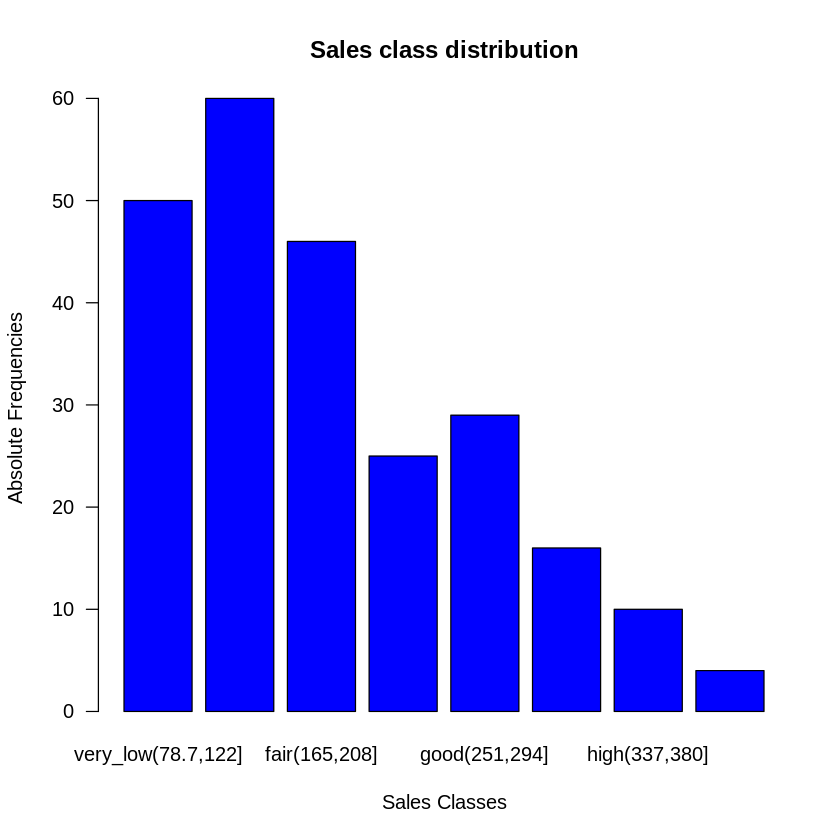

In [39]:
dati_cut_sales <-cut(sales, breaks = 8, labels = c("very_low(78.7,122]","low(122,165]","fair(165,208]","medium(208,251]","good(251,294]","very_good(294,337]","high(337,380]","very_high(380,423]") )
ni<-table(dati_cut_sales)
N<-dim(df)[1]
fi<-ni/N
Fi<-cumsum(fi)
Ni<-cumsum(ni)

tabella_frequenze_sales<-cbind(ni,fi,Ni,Fi) 

barplot_sales <- barplot(ni,                                  
                         main = "Sales class distribution",
                         xlab = "Sales Classes",
                         ylab = "Absolute Frequencies",
                         col = "blue",
                         las = 1)

dev.new(width=2000, height=4)
plot(barplot_sales)

In [22]:
gini <- function(x){  
  ni = table(x)
  fi = ni/length(x)
  fi2 = fi^2
  J = length(table(x))
  
  gini = 1-sum(fi2)
  gini.norm = gini/((J-1)/J)
  
  return(gini.norm)
}

round(gini(dati_cut_sales),2)                              

[1] 0.94

Use boxplots to compare the distribution of the median price of houses between cities

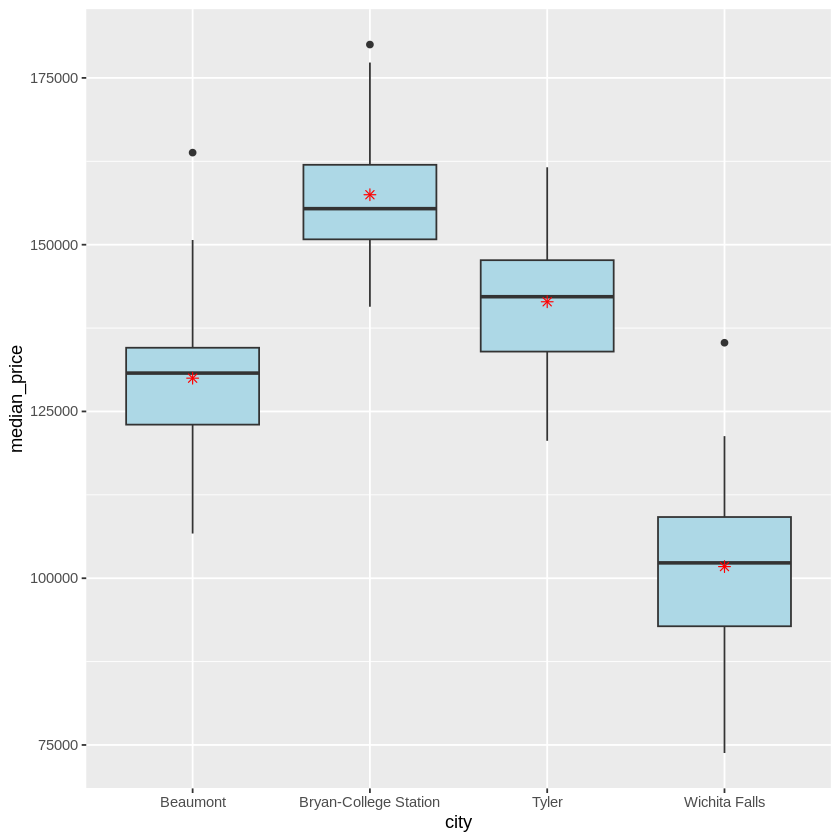

In [76]:
ggplot(data = df)+
  geom_boxplot(aes(
    x=city,
    y=median_price),
    fill="lightblue")+
  stat_summary(aes(
    x=city,
    y=median_price),
   fun = "mean", geom = "point", shape = 8,
               size = 2, color = "red")

How to find the number of the observation of the outliers.

In [78]:
median_price_Beaumont<-df[city=="Beaumont","median_price"]
which(median_price_Beaumont>(quantile(median_price_Beaumont,0.75)+IQR(median_price_Beaumont*1.5)))
median_price_Beaumont[1]

[1] 1

[1] 163800

## **Short Report**



*   Symmetry:
   The variables median_price and months_inventory are the only two to have a skewness value between -0.5 and 0.5 and are therefore almost symmetrical
   The other quantitative variables (sales, volume and listing) have a value between 0.5 and 1--> moderately positively skewed
*   Kurtosis(which as stated in ([Kurtosis as Peakedness, 1905 - 2014. R.I.P., Peter H. WESTFALL](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4321753/pdf/nihms-599845.pdf)) does not indicate how sharp the curve is, but how extreme the tails are)):
   The variables months_inventory, volume and sales are almost mesocurtic.
   The median_price and listing variables are slightly pleticuric (-0.6229618 and -0.79179).

*  Frequency distribution (city, year and month): I have not calculated the cumulative and relative frequencies because they are useless in terms of information, in fact
   already the absolute frequency distribution gives a clear picture of the three variables which are perfectly evenly distributed.

*  The variable with the greatest variability is 'median_price' with the highest values for the various indices (sd=22662.15, IQR=32750, range=106200)

*  The most skewed variable is 'volume' with a value of 0.884742

# **3. Bivariate and Multivariate Analysis**

## Efficacy of Advertisement

I believe that in this case one can proceed by calculating two ratios. 

*  `sales`/`listings`: ratio between the amount of active listings ("listings") and the number of sales in that month ("sales") 

  Interpretation: given a certain number of listings how many sales were     made . 

*  `listings`/`daily_inventory`; ratio between "listings" and the amount of time taken to sell the advertisements ("months_inventory").

  Interpretation: estimate of how long it takes to sell a listing

Note: In dividing "sales" by "listings" I assume, not specified in the dataset description, that all sales are due to listings

In [44]:
daily_inventory<-months_inventory*30
efficacy_advertising_time<-signif(listings/daily_inventory,3)
df$efficacy_advertising_time<-efficacy_advertising_time 

efficacy_advertising_sales<-signif(sales/listings,3)*100
df$efficacy_advertising_sales<-paste(efficacy_advertising_sales,"%") 

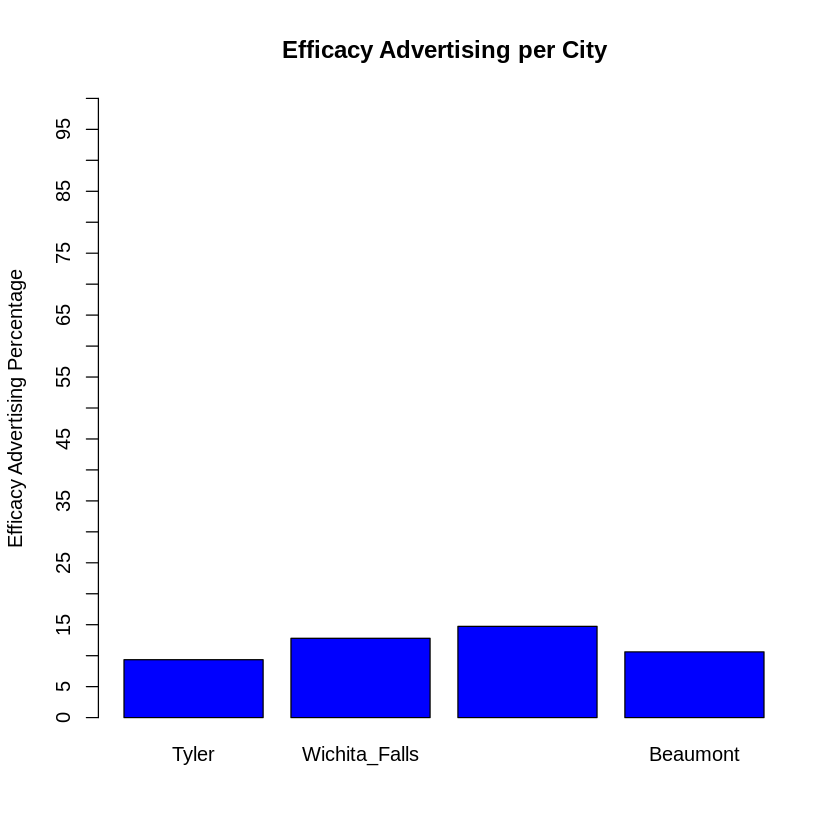

In [56]:
Beaumont_efficacy<-df[city=="Beaumont","efficacy_advertising_sales"]
Beaumont_efficacy<-as.numeric(gsub('%','', Beaumont_efficacy))

Bryan_College_Station_efficacy<-df[city=="Bryan-College Station","efficacy_advertising_sales"]
Bryan_College_Station_efficacy<-as.numeric(gsub('%','', Bryan_College_Station_efficacy))

Tyler_efficacy<-df[city=="Tyler","efficacy_advertising_sales"]
Tyler_efficacy<-as.numeric(gsub('%','', Tyler_efficacy))

Wichita_Falls_efficacy<-df[city=="Wichita Falls","efficacy_advertising_sales"]
Wichita_Falls_efficacy<-as.numeric(gsub('%','', Wichita_Falls_efficacy))

efficacy_advertising_means<-c(mean(Tyler_efficacy),mean(Wichita_Falls_efficacy),
                            mean(Bryan_College_Station_efficacy),mean(Beaumont_efficacy))

barplot(efficacy_advertising_means,
        ylim = c(0,100),
        ylab = "Efficacy Advertising Percentage",
        main = "Efficacy Advertising per City",
        names.arg = c("Tyler","Wichita_Falls","Bryan_College_Station","Beaumont"),
        col = "blue",
        las= 1,
        axes = F)
axis(2,at=seq(0,100,by=5),labels=T)

In [61]:
print("Wichita_Falls_efficacy")
summary(Wichita_Falls_efficacy)
print("Tyler_efficacy")
summary(Tyler_efficacy)
print("Bryan_College_Station_efficacy")
summary(Bryan_College_Station_efficacy)
print("Beaumont_efficacy")
summary(Beaumont_efficacy)

[1] "Wichita_Falls_efficacy"


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   8.32   11.07   12.40   12.80   13.93   18.50 

[1] "Tyler_efficacy"


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  5.010   7.685   9.235   9.348  10.500  14.800 

[1] "Bryan_College_Station_efficacy"


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  6.350   9.262  12.550  14.735  18.000  38.700 

[1] "Beaumont_efficacy"


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  5.410   8.912  10.300  10.617  11.875  16.500 

Taking 'efficacy_advertising_sales (sales/listings)' into consideration, it turns out that the range of percentage averages goes from a minimum of 9.35%(Tyler) to a maximum of 14.74%(Bryan_college_station).

## Creating summaries by different statistics and variables

In [ ]:
city_sales<-df %>%
            group_by(city) %>%
            summarise(av_sales=round(mean(sales),2),
                      median_sales=median(sales),
                      sd_sales=sd(sales))

year_city_sales<-df %>%
                 group_by(year,city) %>%
                 summarise(av_sales=round(mean(sales),2),
                           median_sales=median(sales),
                           sd_sales=sd(sales))

month_city_sales<-df %>%
                  group_by(month,city) %>%
                  summarise(av_sales=round(mean(sales),2),
                            median_sales=median(sales),
                            sd_sales=sd(sales))

Creating time series `year_city_sales`

In [ ]:
sales_year_Beaumont<-filter(year_city_sales,city=="Beaumont")
sales_year_Tyler<-filter(year_city_sales,city=="Tyler")
sales_year_Wichita_Falls<-filter(year_city_sales,city=="Wichita Falls")
sales_year_Bryan_College_Station<-filter(year_city_sales,city=="Bryan-College Station")

sales_year_city<-ggplot(sales_year_Beaumont)+
    
    geom_point(aes(x=year,y=av_sales,col="Beaumont"),lwd=4)+  
    geom_point(data=sales_year_Tyler,aes(x=year,y=av_sales,col="Tyler"),lwd=4)+
    geom_point(data=sales_year_Wichita_Falls,aes(x=year,y=av_sales,col="Wichita Falls"),lwd=4)+
    geom_point(data=sales_year_Bryan_College_Station,aes(x=year,y=av_sales,col="Bryan-College Station"),lwd=4)+
    
    geom_line(aes(x=year,y=av_sales,col="Beaumont"),lwd=1)+
    geom_line(data=sales_year_Tyler,aes(x=year,y=av_sales,col="Tyler"),lwd=1)+
    geom_line(data=sales_year_Wichita_Falls,aes(x=year,y=av_sales,col="Wichita Falls"),lwd=1)+
    geom_line(data=sales_year_Bryan_College_Station,aes(x=year,y=av_sales,col="Bryan-College Station"),lwd=1)+
    
    geom_text(data=sales_year_Tyler,aes(x=year,y=av_sales+10,label=av_sales),size=3.5)+
    geom_text(data=sales_year_Wichita_Falls,aes(x=year,y=av_sales+5,label=av_sales), size=3.5)+
    geom_text(data=sales_year_Bryan_College_Station,aes(x=year,y=av_sales+8,label=av_sales),size=3.5)+
    geom_text(aes(x=year,y=av_sales-8,label=av_sales),size=3.5)+
    
    labs(x="Years",
         y="Average Sales",
         title="Sales Trend by City")+
    scale_y_continuous(breaks = seq(0,350,25))+
    scale_color_manual(
      name   = 'City',
      breaks = c('Beaumont', 'Tyler',"Wichita Falls","Bryan-College Station"),
      values = c("red", "green3","cyan","orange"),
      labels = c('Beaumont', 'Tyler',"Wichita Falls","Bryan-College Station"))

Creating time series `month_city_sales`

In [ ]:
sales_month_B<-filter(month_city_sales,city=="Beaumont")
sales_month_T<-filter(month_city_sales,city=="Tyler")
sales_year_WF<-filter(month_city_sales,city=="Wichita Falls")
sales_year_BCS<-filter(month_city_sales,city=="Bryan-College Station")

sales_months_city<-ggplot(sales_month_B)+
  
  geom_point(aes(x=month,y=av_sales,col="Beaumont"),lwd=4)+  
  geom_point(data=sales_month_T,aes(x=month,y=av_sales,col="Tyler"),lwd=4)+
  geom_point(data=sales_year_WF,aes(x=month,y=av_sales,col="Wichita Falls"),lwd=4)+
  geom_point(data=sales_year_BCS,aes(x=month,y=av_sales,col="Bryan-College Station"),lwd=4)+
  
  geom_line(aes(x=month,y=av_sales,col="Beaumont"),lwd=1)+
  geom_line(data=sales_month_T,aes(x=month,y=av_sales,col="Tyler"),lwd=1)+
  geom_line(data=sales_year_WF,aes(x=month,y=av_sales,col="Wichita Falls"),lwd=1)+
  geom_line(data=sales_year_BCS,aes(x=month,y=av_sales,col="Bryan-College Station"),lwd=1)+
  
  geom_text(data=sales_month_T,aes(x=month,y=av_sales+10,label=av_sales),size=3.5)+
  geom_text(data=sales_year_WF,aes(x=month,y=av_sales+5,label=av_sales), size=3.5)+
  geom_text(data=sales_year_BCS,aes(x=month,y=av_sales-5,label=av_sales),size=3.5)+
  geom_text(aes(x=month,y=av_sales+5,label=av_sales),size=3.5)+
  
  labs(x="Months",
       y="Average Sales",
       title="Sales Trend by City")+
  scale_y_continuous(breaks = seq(0,350,25))+
  scale_x_continuous(breaks = seq(0,12,1))+
  scale_color_manual(
    name   = 'City',
    breaks = c('Beaumont', 'Tyler',"Wichita Falls","Bryan-College Station"),
    values = c("red", "green3","cyan","orange"),
    labels = c('Beaumont', 'Tyler',"Wichita Falls","Bryan-College Station"))

Plotting the two time series together

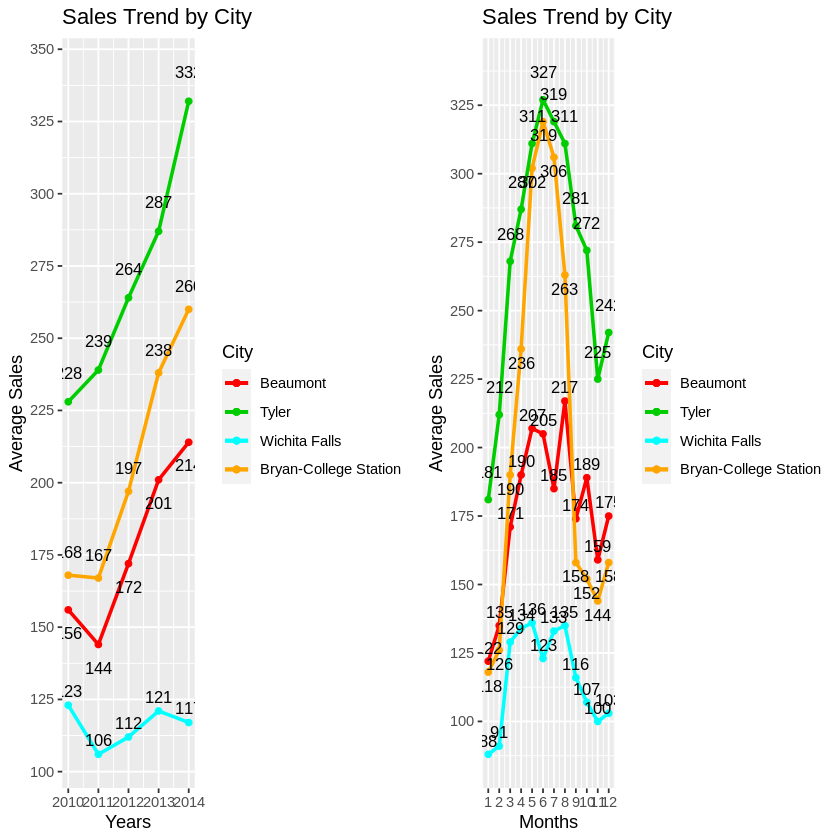

In [74]:
complete_line_chart<-gridExtra::grid.arrange(sales_year_city, sales_months_city, ncol=2)

Again, you're warmly invited to run the code on RStudio or see the correctly displayed plot in the folder ["plot"](https://github.com/giuseppecurci/Real_Estate_Texas_Data_Analysis/tree/main/Plot).

We create boxplots to see how `sales` vary with other variables.

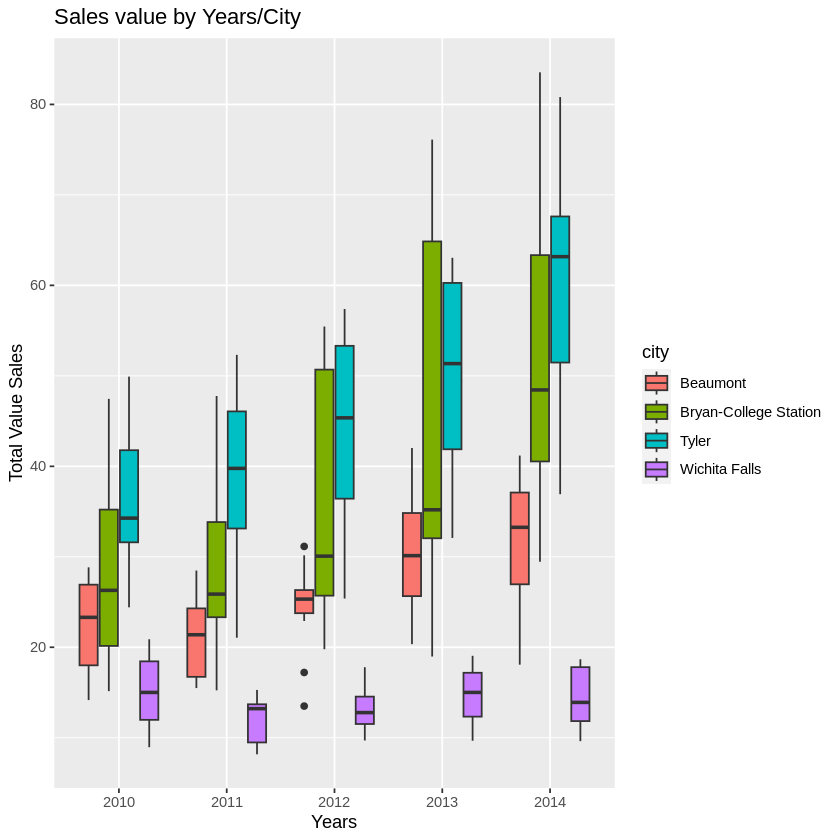

In [81]:
ggplot(data = df)+    
  geom_boxplot(aes(                  
    x=as.factor(year),
    y=volume,
    fill=city))+
  labs(
    y="Total Value Sales",
    title = "Sales value by Years/City"
  )+
  labs(x="Years")

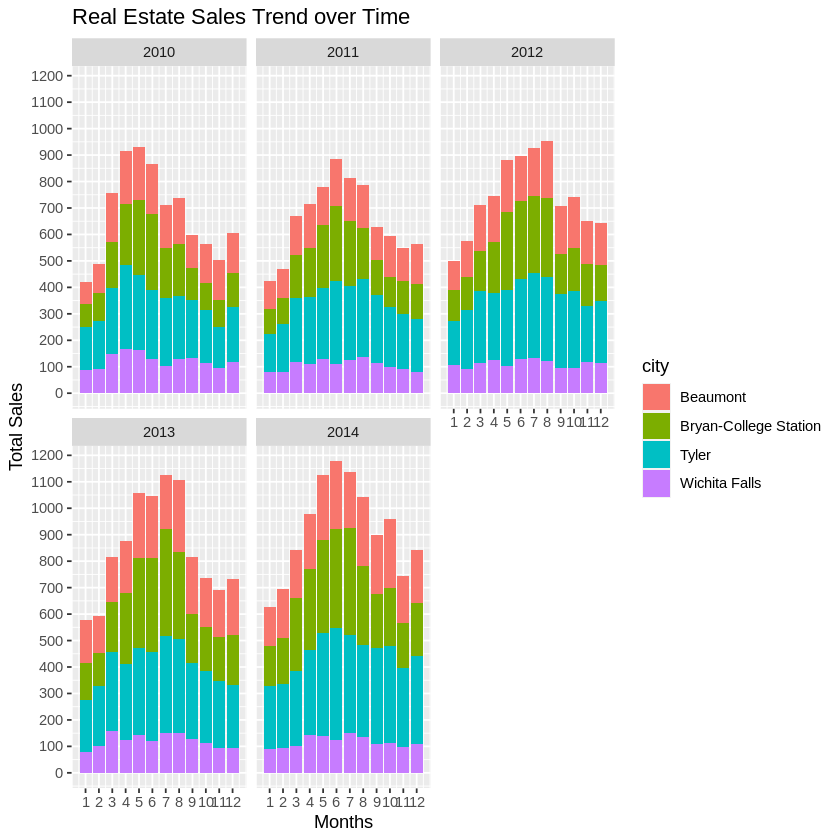

In [84]:
ggplot(df)+
  geom_col(aes(
    x=month,
    y=sales,
    fill=city))+
  scale_x_continuous(breaks= seq(1,12,1))+
  scale_y_continuous(breaks= seq(0,1200,100))+
  labs(x="Months",
       y="Total Sales",
       title="Real Estate Sales Trend over Time")+
  facet_wrap(~year)

Normalized version of the above plot

In [ ]:
x <-df %>%
  group_by(year,month,city) %>%
  summarise(sales=sales)

n=4
y=list()
while(n<=240){
 y = append(y,x$sales[(n-3):(0+n)]/sum(x$sales[(n-3):(0+n)]))
 n=4+n
}

x$sales = y

ggplot(x)+      
  geom_col(aes(
    x=month,
    y=sales,
    fill=city))+
  scale_x_continuous(breaks= seq(1,12,1))+
  labs(x="Mesi",
       y="Total Sales",
       title="Real Estate Sales Trend over Time")+
  facet_wrap(year)